In [3]:
import os
from glob import glob
import numpy as np
import nibabel as nib
import nibabel.processing
import torch
import pandas as pd
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.autograd import Variable
from torchvision import transforms
import torch.nn as nn
from sklearn.metrics import roc_auc_score, average_precision_score
from tqdm import tqdm
from operator import add
import matplotlib.pyplot as plt
import easydict
import dicom2nifti
import dicom2nifti.settings as settings
from scipy.ndimage import zoom
settings.disable_validate_slice_increment() 

In [13]:
label_100 = pd.read_excel('./fileIO/100_Neuroquant5.xlsx')

In [14]:
label_721 = pd.read_csv('./fileIO/current_label.csv')

In [18]:
name100_list = label_100['FOLDERNAME']

In [17]:
name721_list = label_721['FOLDERNAME']

In [22]:
list_621 = set(name721_list) - set(name100_list)

In [32]:
list(list_621)

['26177344_20170125_080943_MR',
 '45186813_20170928_110215_MR',
 '16570650_20171124_111123_MR',
 '40532721_20170112_094312_MR',
 '50351121_20180110_092025_MR',
 '27162941_20170609_101141_MR',
 '26441829_20161227_084224_MR',
 '36283215_20170228_100131_MR',
 '49254578_20170510_091544_MR',
 '50363636_20180523_084101_MR',
 '49137248_20170302_084302_MR',
 '50654286_20180328_094734_MR',
 '33410878_20170502_080210_MR',
 '50189852_20180323_091246_MR',
 '29702004_20160922_104532_MR',
 '48097006_20170525_075424_MR',
 '41837335_20160525_075706_MR',
 '48796031_20161104_093354_MR',
 '48995465_20161222_101333_MR',
 '49093829_20170317_080149_MR',
 '49994566_20171027_075424_MR',
 '49873690_20170911_091802_MR',
 '41705933_20170526_095809_MR',
 '50256916_20180104_094505_MR',
 '49187539_20170414_075343_MR',
 '39963882_20180406_112903_MR',
 '48897958_20180309_102609_MR',
 '49837214_20180125_090132_MR',
 '49124987_20170221_084328_MR',
 '38504521_20180202_084705_MR',
 '47010828_20180510_094254_MR',
 '397772

In [33]:
label_621 = ["FOLDERNAME"]

KeyError: "None of [Index(['26177344_20170125_080943_MR', '45186813_20170928_110215_MR',\n       '16570650_20171124_111123_MR', '40532721_20170112_094312_MR',\n       '50351121_20180110_092025_MR', '27162941_20170609_101141_MR',\n       '26441829_20161227_084224_MR', '36283215_20170228_100131_MR',\n       '49254578_20170510_091544_MR', '50363636_20180523_084101_MR',\n       ...\n       '49489824_20170615_075507_MR', '37605166_20160311_081215_MR',\n       '49532944_20170626_075421_MR', '34333107_20160502_100843_MR',\n       '48371393_20171212_075642_MR', '38482690_20180105_081105_MR',\n       '50392362_20180314_104501_MR', '50654983_20180521_075435_MR',\n       '50464445_20180213_095517_MR', '14750063_20171019_083813_MR'],\n      dtype='object', length=621)] are in the [columns]"

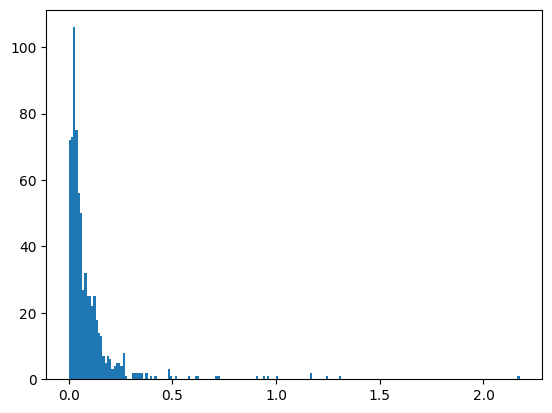

mean:  0.09436019417475727
std:  0.16093700935886995


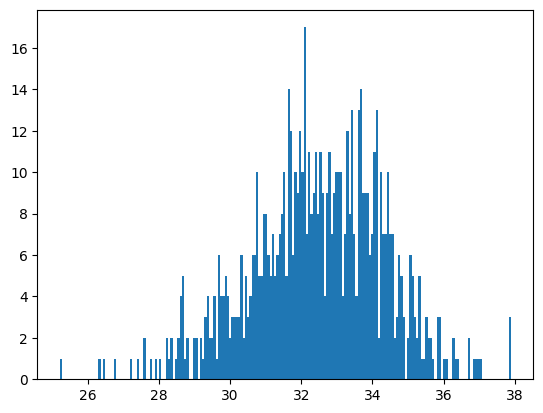

mean:  32.43937905686547
std:  1.885863840226764


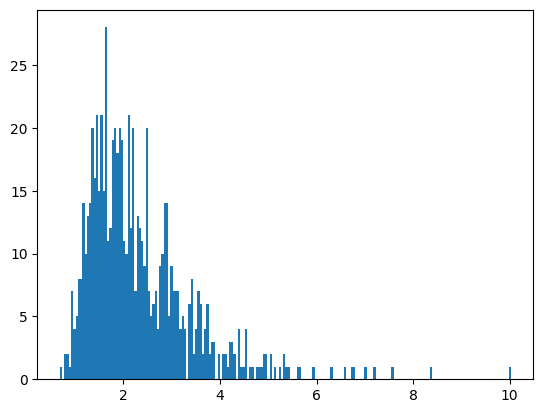

mean:  2.327824826629681
std:  1.1046085958732712


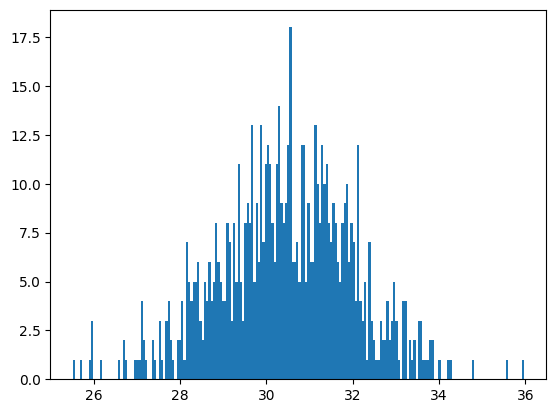

mean:  30.438400277392514
std:  1.573388979206657


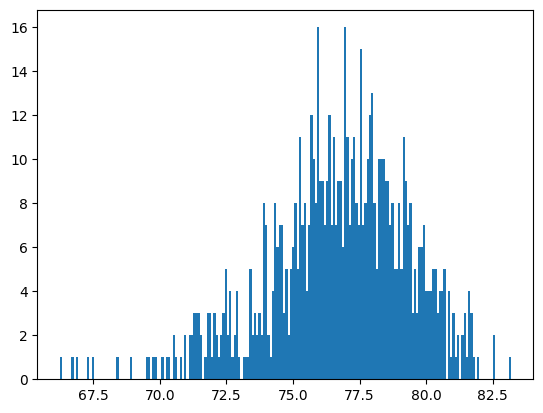

mean:  76.69276601941748
std:  2.6679946372575


In [5]:
for i in range(5):
    plt.hist(label[:,i], bins = 200)
    plt.show()
    print("mean: ", label[:,i].mean())
    print("std: ",label[:, i].std())

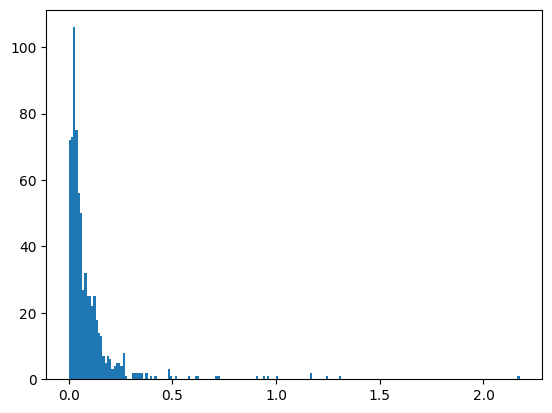

mean:  0.09436019417475727
std:  0.16093700935886995


In [6]:
plt.hist(label[:,0], bins = 200)
plt.show()
print("mean: ", label[:,0].mean())
print("std: ",label[:, 0].std())

In [17]:
label_big_half = label[:,0] > 0.25

In [18]:
big_idx = []
for i, x in enumerate(label_big_half):
    if x == True:
        big_idx.append(i)
        

In [24]:
big_idx

[16,
 28,
 31,
 35,
 66,
 115,
 120,
 146,
 156,
 273,
 299,
 304,
 306,
 320,
 324,
 325,
 326,
 328,
 329,
 330,
 341,
 345,
 347,
 349,
 350,
 354,
 362,
 365,
 378,
 384,
 395,
 397,
 398,
 403,
 408,
 414,
 416,
 421,
 436,
 438,
 439,
 440,
 485,
 496,
 503,
 513]

In [23]:
label[big_idx, 0]

array([0.3219, 0.9037, 1.1733, 0.6179, 0.2524, 0.2671, 0.3269, 0.264 ,
       0.4784, 0.2702, 0.3756, 0.314 , 0.324 , 0.3124, 0.3443, 0.3451,
       0.5212, 0.3791, 0.266 , 2.1739, 0.2793, 0.3563, 0.9672, 0.9363,
       0.4889, 0.5775, 0.2697, 0.2716, 0.2523, 0.354 , 0.2621, 0.4157,
       1.173 , 0.2518, 1.2413, 1.3062, 0.7277, 0.6219, 0.7094, 0.2528,
       0.4913, 0.2618, 0.3963, 1.0049, 0.4844, 0.3358])